<a href="https://colab.research.google.com/github/weseemahmed/weseemahmed.github.io/blob/master/COVID_Transportation_Trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID Transportation Trends
The global pandemic has completely changed how people move around, even here in Canada. Data from Apple sheds light on these trends for driving, walking, and driving. This notebook will go over how to access and clean these data for further analysis and visualization.

First things first: let's load in the packages we need.

In [ ]:
#specify the packages of interest
packages = c("ggplot2","directlabels","reshape", "readxl", "tidytext", "dplyr", "data.table", "tidyr", "pracma", "stringr", "grid", "zoo")

#use this function to check if each package is on the local machine
#if a package is installed, it will be loaded, else installed then loaded.

package.check <- lapply(packages, FUN = function(x) {
  if (!require(x, character.only = TRUE)) {
    install.packages(x, dependencies = TRUE)
    library(x, character.only = TRUE)
  }
})

### Loading in the data
Next we load in the data. Apple provides this data but only in csv format, meaning that everytime it updates (ie. everyday), we'd have to reload the data and run this script again. ActiveConclusion on github has made this data readily available with daily automatic updates.

To load it, I use the `fread` command from `data.table` and simply plug in the url:

In [9]:
# Read in Apple mobility data from Github
mobility <- fread("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/apple_reports/applemobilitytrends.csv", header = T)

In [6]:
head(mobility)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,⋯,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31
country/region,Albania,driving,,,,100.0,95.3,101.43,97.2,⋯,113.05,118.95,126.12,132.18,130.38,120.18,115.54,114.57,128.96,146.62
country/region,Albania,walking,,,,100.0,100.68,98.93,98.46,⋯,134.75,136.38,138.34,133.82,169.04,158.21,149.55,155.01,159.23,170.66
country/region,Argentina,driving,,,,100.0,97.07,102.45,111.21,⋯,58.52,78.61,80.43,37.91,60.02,62.89,60.59,70.7,83.31,88.62
country/region,Argentina,walking,,,,100.0,95.11,101.37,112.67,⋯,43.31,60.31,61.53,25.54,50.33,55.48,47.05,53.69,64.08,66.53
country/region,Australia,driving,AU,,,100.0,102.98,104.21,108.63,⋯,102.98,97.19,77.39,87.4,92.13,96.71,97.06,108.39,104.59,86.59


### Cleaning the data
Now that we have it loaded, we need to clean it to get it in a format useful for us. For this I use the famous `dplyr` package and filter `region` for the Canadian cities listed in the dataset. Then I select which columns to keep and lastly pivot the table so that it's in long format.

In [10]:
# Pipeline to process the data and pull out Canadian cities
mobility <- mobility %>%
  filter(region %in% c("Calgary", "Edmonton", "Halifax", "Montreal", "Ottawa", "Toronto", "Vancouver")) %>%
  select(-c(1,4:6)) %>% #Remove undeeded columns and update with new dates
  pivot_longer(-c(region, transportation_type), names_to = "Date", values_to = "Index") 

### Some data cleaning
Next we have to clean the data up a bit. First is to get `transportation_type` into sentence case and `Date` into date format.

After that we need to generate a 7-day moving average of the data to plot a smooth curve. NOTE: This needs to be done by both `region` and `transportation_type` or else the function will simply go down the column and average out different modes of transportation and cities.

In [11]:
# Change data type of these two columns
mobility$transportation_type <- str_to_sentence(mobility$transportation_type)
mobility$Date <- as.Date(mobility$Date)

In [12]:
# Get 7-day moving average
setDT(mobility)[, "MA" := frollmean(Index, 7),
          .SDcols = c("Index","transportation_type"),
          by = list(region, transportation_type)]

Warning message in `[.data.table`(setDT(mobility), , `:=`("MA", frollmean(Index, :
“This j doesn't use .SD but .SDcols has been supplied. Ignoring .SDcols. See ?data.table.”


### Plotting
Next we plot our graph. I use the `ggplot2` package; one `geom_line` for the raw data and another for the moving average. Then I add some features to make it more readable: an intercept at 100 to show the baseline, a rectangle to show the week lockdowns began, and a dashed line to show Labour day.

From there I set my prefered themes and customizations and voila!

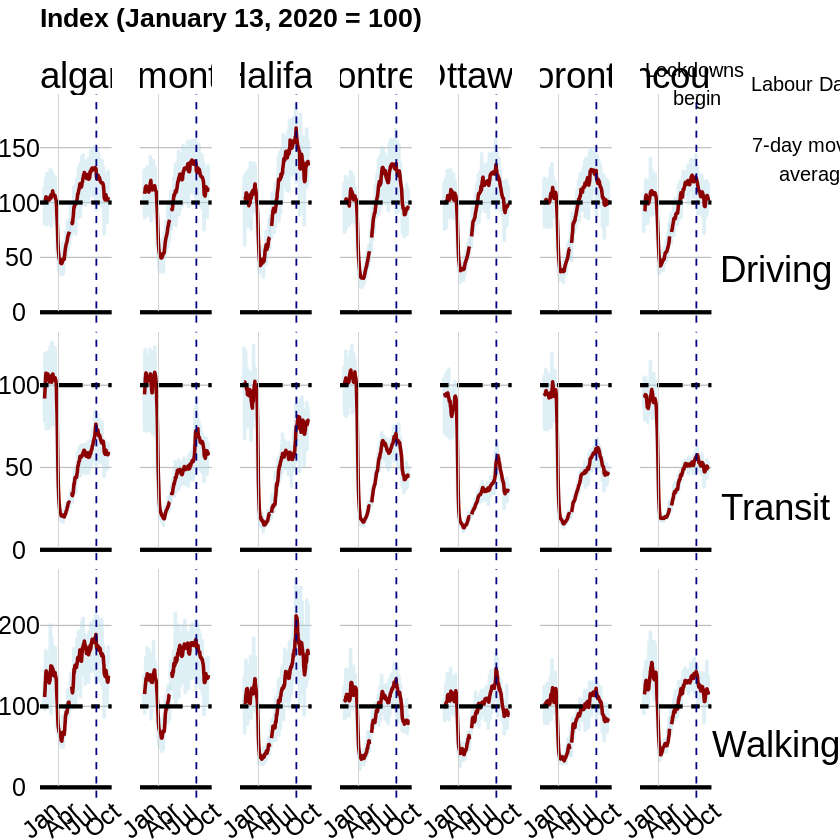

In [14]:
# Create figure
ggplot(mobility) + 
  geom_line(aes(x=Date, Index, group = 1), size=1, color="lightblue", alpha = .4, na.rm = T) +
  geom_line(aes(x=Date, MA, group = 1), size=1, color="darkred", na.rm = T) +
  
  geom_hline(yintercept = 100, linetype = "twodash", size = 1.2) +
  geom_hline(yintercept = 0, linetype = "solid", size = 1.2) +
  geom_vline(xintercept = as.Date("2020-09-07"), linetype = "dashed", color = "navyblue") +
  geom_rect(aes(xmin = as.Date("2020-03-17"), xmax = as.Date("2020-03-22"), ymin = 1, ymax = Inf), alpha = .1, fill = "lightgrey") +
  theme_void() +
  facet_grid(transportation_type ~ region, scales = "free") +
  labs(title = "Index (January 13, 2020 = 100)\n",
       x = "Month") +

  
  theme(plot.title = element_text(size = 16, face = "bold"),
        strip.text = element_text(size = 22, vjust = .2),
        axis.text=element_text(size=15),
        strip.background = element_rect(colour = "white"),
        strip.text.x = element_text(vjust = .9),
        #axis.title=element_text(size=22, vjust = 2),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        axis.text.x =element_text(colour="black", angle = 40),
        axis.text.y=element_text(colour="black"),
        panel.grid.minor = element_blank(),
        panel.grid.major.y = element_line(colour = "grey"),
        panel.spacing.x = unit(6, "mm"))

# Add some text
grid.text("Labour Day", x = .955, y = .9)
grid.text("Lockdowns \nbegin", x = .83, y = .9)
grid.text("7-day moving \naverage", x = .97, y = .81)